In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, roc_curve, auc

%matplotlib inline

In [2]:
# Full path of the 'orders' dataset
orders_file = 'https://www.dropbox.com/s/ej64qorm1uvmjlp/olist_orders_dataset.csv?dl=1'

# Full path of the 'customer' dataset
cust_file = 'https://www.dropbox.com/s/t082qlggu4wxiq5/olist_customers_dataset.csv?dl=1'

# File output location
out = r"C:\Users\scheerja\Downloads"

In [3]:
#read into dataframes
def read_olist_data(file1, file2):
    
    # Read the orders data
    orders = pd.read_csv(file1)

    print (f'{len(orders):,d} read from the orders file.')

    # Drop unnecessary columns
    drop_vars = ['order_delivered_carrier_date']

    orders = orders.drop(drop_vars, axis=1)

    # Date-time conversion
    orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
    orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
    orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
    orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])

    # Let's convert the order purchase timestamps into dates
    orders['order_purchase_date'] = orders['order_purchase_timestamp'].dt.date

    # Extract month from the order date
    orders['order_month'] = orders['order_purchase_timestamp'].dt.month

    # Read the file that contains the unique customer identifier
    cust = pd.read_csv(file2)

    print (f'{len(cust):,d} read from the customer file.')

    # Let's keep only the following two columns: customer_id, customer_unique_id
    cust = cust[['customer_id', 'customer_unique_id', 'customer_city', 'customer_state']]

    # Merge orders and cust dataframes
    orders = pd.merge(orders, cust, on='customer_id', how='inner')
    
    print (f'{len(orders):,d} records in the output  file.')
    
    return orders

orders = read_olist_data(orders_file, cust_file)

orders.head()

99,441 read from the orders file.
99,441 read from the customer file.
99,441 records in the output  file.


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date,order_month,customer_unique_id,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,2017-10-02,10,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13,2018-07-24,7,af07308b275d755c9edb36a90c618231,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04,2018-08-08,8,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15,2017-11-18,11,7c142cf63193a1473d2e66489a9ae977,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26,2018-02-13,2,72632f0f9dd73dfee390c9b22eb56dd6,santo andre,SP


In [4]:
#subset data prior to prediction window
print (len(orders))

# Select data prior to the prediction window
snapshot_date = date(2018, 2, 28)

attr_raw = orders[orders['order_purchase_timestamp'].dt.date <= snapshot_date]

len(orders), len(attr_raw)

99441


(99441, 59427)

In [5]:
#create customer recency feature
cust_recency = attr_raw.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()

snapshot_date = date(2018, 7, 31)

delta = snapshot_date - cust_recency.order_purchase_timestamp.dt.date

cust_recency['order_recency'] = delta.dt.days
cust_recency = cust_recency.drop('order_purchase_timestamp', axis=1)

#create total orders feature
cust_orders = orders.groupby('customer_unique_id').size().reset_index()

cust_orders = cust_orders.rename(columns={0: 'total_orders'})

#merge total orders and recency
attr = pd.merge(cust_recency, cust_orders, on='customer_unique_id', how='left')
attr.head()



,customer_unique_id,order_recency,total_orders
0,0000f46a3911fa3c0805444483337064,508,1
1,0000f6ccb0745a6a4b88665a16c9f078,292,1
2,0004aac84e0df4da2b147fca70cf8255,259,1
3,00053a61a98854899e70ed204dd4bafe,153,1
4,0005e1862207bf6ccc02e4228effd9a0,514,1


In [6]:
#create average delivery delta feature - time difference between estimated and actual delivery date
attr_raw['avg_delivery_delta'] = attr_raw.order_estimated_delivery_date.dt.date - attr_raw.order_delivered_customer_date.dt.date
attr_raw['avg_delivery_delta_days'] = attr_raw['avg_delivery_delta'].dt.days
cust_delivery = attr_raw.groupby('customer_unique_id')['avg_delivery_delta_days'].mean().reset_index()
#merge
attr1 = pd.merge(attr, cust_delivery, on='customer_unique_id', how='left')
attr1.head()




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,customer_unique_id,order_recency,total_orders,avg_delivery_delta_days
0,0000f46a3911fa3c0805444483337064,508,1,2.0
1,0000f6ccb0745a6a4b88665a16c9f078,292,1,12.0
2,0004aac84e0df4da2b147fca70cf8255,259,1,8.0
3,00053a61a98854899e70ed204dd4bafe,153,1,10.0
4,0005e1862207bf6ccc02e4228effd9a0,514,1,28.0


In [7]:
#create average order to approval time feature - time from customer order to approval timestamp

attr_raw['avg_order_to_approval_time'] = attr_raw.order_approved_at.dt.date - attr_raw.order_purchase_timestamp.dt.date
attr_raw['avg_order_to_approval_time'] = attr_raw['avg_order_to_approval_time'].dt.days
order_approval_time = attr_raw.groupby('customer_unique_id')['avg_order_to_approval_time'].mean().reset_index()
#merge
attr2 = pd.merge(attr1, order_approval_time, on='customer_unique_id', how='left')
attr2.head()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,customer_unique_id,order_recency,total_orders,avg_delivery_delta_days,avg_order_to_approval_time
0,0000f46a3911fa3c0805444483337064,508,1,2.0,0.0
1,0000f6ccb0745a6a4b88665a16c9f078,292,1,12.0,0.0
2,0004aac84e0df4da2b147fca70cf8255,259,1,8.0,0.0
3,00053a61a98854899e70ed204dd4bafe,153,1,10.0,0.0
4,0005e1862207bf6ccc02e4228effd9a0,514,1,28.0,0.0


In [8]:
#create proportion of orders fulfilled feature - % of customer's orders with 'delivered' order status
attr_raw['order_delivered'] = np.where(attr_raw['order_status'].str.contains("delivered", case=False, na=False), 1, 0)
delivered_total = attr_raw.groupby('customer_unique_id')['order_delivered'].sum().reset_index()
#merge
attr3 = pd.merge(attr2, delivered_total, on='customer_unique_id', how='left')
#create proportion from total
attr3['order_proportion_delivered'] = attr3.order_delivered / attr3.total_orders
attr3 = attr3.drop('order_delivered', axis = 1)
#completed dataset with 5 attributes
attributes = attr3
attributes.head()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,customer_unique_id,order_recency,total_orders,avg_delivery_delta_days,avg_order_to_approval_time,order_proportion_delivered
0,0000f46a3911fa3c0805444483337064,508,1,2.0,0.0,1.0
1,0000f6ccb0745a6a4b88665a16c9f078,292,1,12.0,0.0,1.0
2,0004aac84e0df4da2b147fca70cf8255,259,1,8.0,0.0,1.0
3,00053a61a98854899e70ed204dd4bafe,153,1,10.0,0.0,1.0
4,0005e1862207bf6ccc02e4228effd9a0,514,1,28.0,0.0,1.0


In [9]:
#targeting


mask = (orders.order_purchase_timestamp.dt.year == 2018) & (orders.order_purchase_timestamp.dt.month == 3)

target_events_raw = orders[mask]

len(target_events_raw)

7211

In [10]:
print (target_events_raw['order_purchase_timestamp'].min(), target_events_raw['order_purchase_timestamp'].max())

2018-03-01 00:00:00 2018-03-31 23:54:10


In [11]:
target_events = target_events_raw.groupby('customer_unique_id').size().reset_index()

target_events.head()
len(target_events)

7115

In [12]:
df = pd.merge(attributes, target_events, how='left', on='customer_unique_id')

df = df.rename(columns={0: 'purch'})

df['purch'] = [1 if x >= 1 else 0 for x in df['purch']]



In [13]:
df.dtypes

customer_unique_id             object
order_recency                   int64
total_orders                    int64
avg_delivery_delta_days       float64
avg_order_to_approval_time    float64
order_proportion_delivered    float64
purch                           int64
dtype: object

In [14]:
df.head()

,customer_unique_id,order_recency,total_orders,avg_delivery_delta_days,avg_order_to_approval_time,order_proportion_delivered,purch
0,0000f46a3911fa3c0805444483337064,508,1,2.0,0.0,1.0,0
1,0000f6ccb0745a6a4b88665a16c9f078,292,1,12.0,0.0,1.0,0
2,0004aac84e0df4da2b147fca70cf8255,259,1,8.0,0.0,1.0,0
3,00053a61a98854899e70ed204dd4bafe,153,1,10.0,0.0,1.0,0
4,0005e1862207bf6ccc02e4228effd9a0,514,1,28.0,0.0,1.0,0


In [15]:
#correlations

df[['order_recency', 'total_orders','avg_delivery_delta_days', 'avg_order_to_approval_time', 'order_proportion_delivered', 'purch']].corr()

,order_recency,total_orders,avg_delivery_delta_days,avg_order_to_approval_time,order_proportion_delivered,purch
order_recency,1.000000,-0.034159,0.201047,0.011516,-0.050249,-0.016843
total_orders,-0.034159,1.000000,0.013674,-0.004798,-0.136478,0.256306
avg_delivery_delta_days,0.201047,0.013674,1.000000,-0.054756,-0.004394,0.002814
avg_order_to_approval_time,0.011516,-0.004798,-0.054756,1.000000,-0.035193,-0.001486
order_proportion_delivered,-0.050249,-0.136478,-0.004394,-0.035193,1.000000,-0.126542
purch,-0.016843,0.256306,0.002814,-0.001486,-0.126542,1.000000


In [16]:
#create new df with na values filled by column median value
df_fill = df
df_fill['avg_delivery_delta_days'] = df_fill['avg_delivery_delta_days'].fillna(df_fill['avg_delivery_delta_days'].median())
df_fill['avg_order_to_approval_time'] = df_fill['avg_order_to_approval_time'].fillna(df_fill['avg_order_to_approval_time'].median())

In [17]:
#correlations of filled df

df_fill[['order_recency', 'total_orders','avg_delivery_delta_days', 'avg_order_to_approval_time', 'order_proportion_delivered', 'purch']].corr()

#are the differences acceptible? I'm not really sure...

,order_recency,total_orders,avg_delivery_delta_days,avg_order_to_approval_time,order_proportion_delivered,purch
order_recency,1.000000,-0.034159,0.197129,0.011112,-0.050249,-0.016843
total_orders,-0.034159,1.000000,0.013214,-0.004741,-0.136478,0.256306
avg_delivery_delta_days,0.197129,0.013214,1.000000,-0.039661,-0.017959,0.002784
avg_order_to_approval_time,0.011112,-0.004741,-0.039661,1.000000,-0.032992,-0.001462
order_proportion_delivered,-0.050249,-0.136478,-0.017959,-0.032992,1.000000,-0.126542
purch,-0.016843,0.256306,0.002784,-0.001462,-0.126542,1.000000


In [18]:
#model/training setup

preds = ['order_recency', 'total_orders','avg_delivery_delta_days', 'avg_order_to_approval_time', 'order_proportion_delivered']

X = df_fill[preds]
y = df_fill['purch']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=314)

len(X_train), len(X_test)

(28755, 28755)

# Logitistic Regression Modeling and Testing

In [20]:
# Define the model object
clf = LogisticRegression(solver='liblinear', random_state=314)

# Train (fit) the model using the training sample
clf.fit(X_train, y_train)

# Make predictions on the test sample
preds_test = clf.predict(X_test)

In [21]:
#logistic regression model testing
#ROC curve
scores_test = clf.predict_proba(X_test)[:, 1]
# Calcualte AUC
roc_auc_score(y_test, scores_test)

0.9826591638304966

In [22]:
#confusion matrix
cmat = confusion_matrix(y_test, preds_test)
cmat
#pd.crosstab(y_test, preds_test)

array([[28674,     8],
       [   72,     1]], dtype=int64)

In [23]:
#precision
precision_score(y_test, preds_test)

0.1111111111111111

In [24]:
#recall
recall_score(y_test, preds_test)

0.0136986301369863

In [25]:
#accuracy score
accuracy_score(y_test, preds_test)

0.9972178751521474

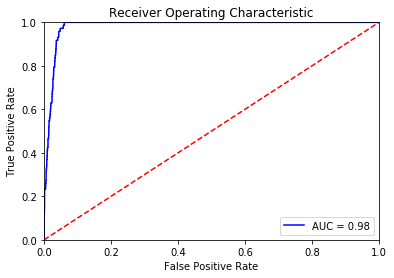

In [26]:
#plot ROC curve
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Random Forest Classifier Modeling and Testing

In [27]:
# Define the model (object)
rfc = RandomForestClassifier()

# Fit (train) the model
rfc.fit(X_train, y_train)

# Make predictions on the test data
preds_test_rfc = rfc.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [28]:
#random forest classifier model testing
#ROC curve
scores_test_rfc = rfc.predict_proba(X_test)[:, 1]
# Calcualte AUC
roc_auc_score(y_test, scores_test_rfc)

0.8715733126499078

In [29]:
#confusion matrix
cmat_rfc = confusion_matrix(y_test, preds_test_rfc)
cmat_rfc
#pd.crosstab(y_test, preds_test)

array([[28651,    31],
       [   71,     2]], dtype=int64)

In [30]:
#accuracy score
accuracy_score(y_test, preds_test_rfc)

0.996452790818988

In [31]:
#precision
precision_score(y_test, preds_test_rfc)

0.06060606060606061

In [32]:
#recall
recall_score(y_test, preds_test_rfc)

0.0273972602739726

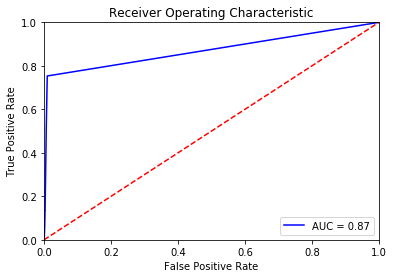

In [33]:
#plot ROC curve
# calculate the fpr and tpr for all thresholds of the classification
probs = rfc.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Conclusion: It is hard to argue that either of these models would be particularly useful to predict future purchases by customers. One likely issue is that this dataset contains very few customers who purchased more than one item to begin with. That said, it appears that the logistic regression model performs a bit better than the random forest classifier above.